In [53]:
%matplotlib inline
from pynq import Overlay
from pynq.lib import AxiGPIO
import time
import numpy as np
import matplotlib.pyplot as plt

In [54]:
GPIO = Overlay('antminerGPIO.bit')

miner0[0:3] -- OS0[0:3]
miner0[3]  --  RST

miner1[0:2] -- STA, STB
miner1[2]  --  BUSY

miner2[]
miner2[1:3]
miner2[3] 

In [55]:
miner_instance_0 = GPIO.ip_dict["plMiner0"]
miner_instance_1 = GPIO.ip_dict["plMiner1"]
miner_instance_2 = GPIO.ip_dict["plMiner2"]
miner0 = AxiGPIO(miner_instance_0).channel1  # 数字滤波器， 复位
miner1 = AxiGPIO(miner_instance_1).channel1  # 转换控制， busy
miner2 = AxiGPIO(miner_instance_2).channel1  # spi口

In [56]:
def GPIOreset(val = 0xff):
    if val == 0:
        miner0.trimask = 0xf;
    elif val == 1:
        miner1.trimask = 0xf;
    elif val == 2:
        miner2.trimask = 0xf;
    else:
        miner0.trimask = 0xf;
        miner1.trimask = 0xf;
        miner2.trimask = 0xf;

In [57]:
def AD7606_SETOS(val = 0x00):  # 数字滤波器设置
    miner0[0:3].write(val & 0x7)

In [58]:
def AD7606_RESET():  # 重置AD7606
    miner0[3].on()
    time.sleep(0.05)
    miner0[3].off()

In [59]:
def AD7606_BUSY():  # 获取是否正在转换
    status = (miner1.read() & 0x08)
    return status

In [60]:
def AD7606_STARTCONV():  # 开始转换指令
    miner1[0:2].off()
#     time.sleep(0.0001)
    miner1[0:2].on()

In [61]:
def AD7606_FREEZECONV():  # 拉高待机
    miner1[0:2].on()

In [62]:
def AD7606_CS_L():  # 片选
    miner2[3].off()

In [63]:
def AD7606_CS_H():  # 取消片选
    miner2[3].on()

In [64]:
def AD7606_SCLK_L():  # 时钟拉低
    miner2[0].off()

In [65]:
def AD7606_SCLK_H():  # 时钟拉高
    miner2[0].on()

In [66]:
def ad7606_ReadBytes():  # 读取一个通道数值
    val = 0
    for i in range(16):
        AD7606_SCLK_L()
        val = val << 1
        if (miner2.read() & 0x02):
            val = val | 0x0001
        AD7606_SCLK_H()
    return val

In [67]:
GPIOreset()  # 恢复所有端口为高阻
AD7606_SETOS(0x00)
AD7606_RESET()
AD7606_FREEZECONV()

In [68]:
# 时钟拉高待命
AD7606_CS_H()
AD7606_SCLK_H()

In [69]:
data = np.zeros((8, 100))

In [71]:
time_start = time.time()
for k in range(100):  # 采集100个点
    AD7606_STARTCONV()
    while AD7606_BUSY():
        pass
    for i in range(8):
        AD7606_CS_L()
        tmp = ad7606_ReadBytes()
        data[i, k] = tmp
        AD7606_CS_H()
#         print(tmp)
totalTime = time.time() - time_start
print(f"耗时{totalTime}秒")

耗时5.31020450592041秒


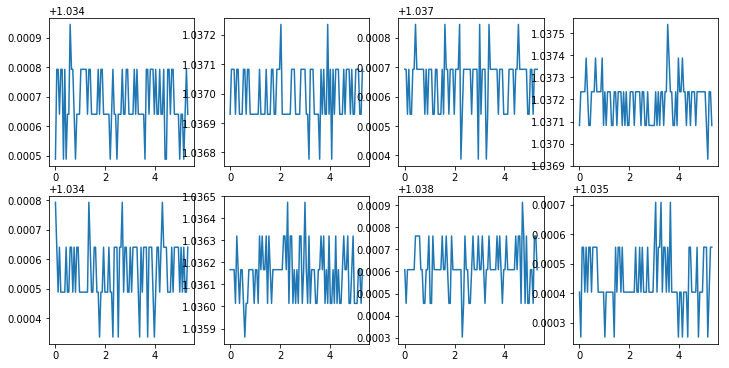

In [72]:
t = np.linspace(0,totalTime,100)
data = data / 6553
canvas = plt.gcf()
canvas.set_size_inches((12,6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.plot(t, data[i, :])
plt.show()